# Scraping subreddits


## Part II - Preprocessing & EDA
---

We'll import all our required libraries up here.

In [76]:
#import libraries

import pandas as pd, numpy as np, requests, time, nltk, datetime as dt, matplotlib.pyplot as plt, seaborn as sns

#NLP transformers
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import gensim.downloader as api #allows us to get word2vec anf glove embeddings that we need
from gensim.models.word2vec import Word2Vec
from transformers import pipeline
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


#classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text


#metrics / model preprocessing
from sklearn.metrics import (accuracy_score, confusion_matrix, plot_confusion_matrix, \
                             recall_score, precision_score)
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier


# easier to see full text with a bigger maxwidth:
pd.options.display.max_colwidth = 200

#show grid on plots
sns.set_style('darkgrid')

In [2]:
#pip install python-Levenshtein
#this is for the gensim.similarities.levenshtein submodule

- - - 

### Pull in the files, resulting from our scrapes, into dataframes!

In [3]:
movie_deets2 = pd.read_csv('../data_outputs/good_movie_deets2.csv')
bad_deets2 = pd.read_csv('../data_outputs/bad_movie_deets2.csv')
all_movies = pd.read_csv('../data_outputs/all_movies.csv')

### Get basic stats

Let's look at basic stats about our data.

How many records do we have, prior to cleaning?

In [4]:
movie_deets2.shape

(8805, 9)

In [5]:
bad_deets2.shape

(8180, 9)

In [6]:
all_movies.shape

(9404, 9)

What did we pull in?

In [7]:
movie_deets2.head(2)

,title,selftext,subreddit,created_utc,author,is_self,score,num_comments,timestamp
0,"Listen,share,repost ""culgrin d mayor"" Africa gorilla volume 1 EP on all PLATFORMS",NaN,MovieDetails,1619213155,culgrin1,False,1,0,2021-04-23
1,"In Repo Man (1984), Miller says to Otto “suppose you're thinkin' about a plate o' shrimp. Suddenly someone'll say, plate, or shrimp, or plate o' shrimp out the blue” as an example of his concept o...",NaN,MovieDetails,1619214866,VictorBlimpmuscle,False,1,12,2021-04-23


In [8]:
bad_deets2.head(2)

,title,selftext,subreddit,created_utc,author,is_self,score,num_comments,timestamp
0,"In the movie Bullworth (1998), a police officer is seen not shooting black people.",NaN,shittymoviedetails,1619214935,Wuz314159,False,1,1,2021-04-23
1,"The Nightmare Before Christmas (1993), when he arrives at Christmas Town, Jack sings ""what's this? There's white things in the air"". 22 seconds later he sings ""there are children throwing snowball...",NaN,shittymoviedetails,1619217853,Nerf_Herder86,False,1,0,2021-04-23


In [9]:
all_movies.head(2)

,title,selftext,subreddit,created_utc,author,is_self,score,num_comments,timestamp
0,Russian sci-fi film about artificial intelligence testing.,NaN,movies,1619216594,Anixx,False,1,0,2021-04-23
1,"Just why! Miranda is not in the Lizzie McGuire Movie and while the movie was still good, there's a huge hole without Miranda especially when they go to a country like Rome. And Miranda was already...",[removed],movies,1619217134,EvilIceCream1755,True,1,0,2021-04-23


Let's actually merge our dataframes to make it easier for processing.

In [10]:
#pd.concat([df1, df2])
df = pd.concat([bad_deets2, movie_deets2, all_movies])
df.head(1)

,title,selftext,subreddit,created_utc,author,is_self,score,num_comments,timestamp
0,"In the movie Bullworth (1998), a police officer is seen not shooting black people.",NaN,shittymoviedetails,1619214935,Wuz314159,False,1,1,2021-04-23


In [11]:
df.shape

(26389, 9)

What data types are we dealing with?

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26389 entries, 0 to 9403
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         26389 non-null  object
 1   selftext      7350 non-null   object
 2   subreddit     26389 non-null  object
 3   created_utc   26389 non-null  int64 
 4   author        26389 non-null  object
 5   is_self       26389 non-null  bool  
 6   score         26389 non-null  int64 
 7   num_comments  26389 non-null  int64 
 8   timestamp     26389 non-null  object
dtypes: bool(1), int64(3), object(5)
memory usage: 1.8+ MB


A few objects, like text fields, are expected, and will need to be transformed / vectorized for modeling.

Let's also convert the time stamps to a usable format, just in case they come in handy for modeling.

A few objects, like text fields, are expected, and will need to be transformed / vectorized for modeling.

Let's also convert the time stamps to a usable format, just in case they come in handy for modeling. Further, the UTC is actually not really something we want in our model, and it's not really numeric either (it's a datetime concept if anything). Let's take care of that as well.

In [13]:
#convert time stamps
#.apply(pd.to_datetime) - ref.: https://stackoverflow.com/questions/26763344/convert-pandas-column-to-datetime
df['timestamp'] = df['timestamp'].apply(pd.to_datetime)
df['created_utc'] = df['created_utc'].apply(pd.to_datetime)

Now we can try to obtain basic descriptive stats.

In [14]:
df.describe().round(1)

,score,num_comments
count,26389.0,26389.0
mean,57.4,18.7
std,1400.0,124.0
min,0.0,0.0
25%,1.0,0.0
50%,1.0,2.0
75%,1.0,5.0
max,72489.0,6036.0


Not much to look at here at the moment. The notables are the distribution of comments. We'll want to perform some more specific distribution analyses a little down the road, once done with the cleaning, to make more sense out of these stats.

Where might we have issues with missing data?

In [15]:
df.isnull().sum()

title               0
selftext        19039
subreddit           0
created_utc         0
author              0
is_self             0
score               0
num_comments        0
timestamp           0
dtype: int64

- - - 

### Imputation and cleaning strategy

Our strategy is to first remove anything with selftext appearing to have been deleted. Even though these are not read as nulls, they effectively are, for our purposes.

We knew that we'd have quite a few issues with missing self-text, when we shose to scrape unfiltered data. To remedy this, we could impute all nulls where self text is missing with the post's title, but this might result in inadvertent text duplicates when we train our model. So, instead, we are going to engineer a new column and merge the self-text and title text. _Note: Attribution for the idea to Riley R._

We will further dedupe and get rid of ostensibly spammy looking posts, by adding stop words like "repost", "reshare", as well as dropping any dominant authors or ones that sound spammy ("bot", "auto").

We will also need to get rid of any link references.

Okay, let's start by dropping anything with the word "removed" or "deleted". It's a tiny portion of our set, so I am not super worried about losing those rows of data.

In [38]:
#df[~df['col'].str.contains('value1|value2')]
#syntactic ref from https://stackoverflow.com/questions/52297740/typeerror-bad-operand-type-for-unary-float

df = df[~df['selftext'].str.contains('deleted|removed', na=False)]

#df = df[df.selftext != 'deleted']
#df = df[df.selftext != 'removed']

In [39]:
#check
df.head(1)

,title,selftext,subreddit,created_utc,author,is_self,score,num_comments,timestamp
0,"In the movie Bullworth (1998), a police officer is seen not shooting black people.",NaN,shittymoviedetails,1970-01-01 00:00:01.619214935,Wuz314159,False,1,1,2021-04-23


Let's confirm that those bad rows are gone.

In [43]:
#check again that removed and deleted selftexts are no longer in frame
df['selftext'].value_counts().sort_values(ascending=False)[:3]

[https://www.reddit.com/r/Paintings\_in\_movies/comments/j6f34d/sascha\_schneider\_hypnose\_1904\_vs\_the\_lighthouse/?utm\_source=share&amp;utm\_medium=web2x&amp;context=3](https://www.reddit.com/r/Paintings_in_movies/comments/j6f34d/sascha_schneider_hypnose_1904_vs_the_lighthouse/?utm_source=share&amp;utm_medium=web2x&amp;context=3)    2
Rachel Marrons sister hires a hitman to kill her successful sister but the reasons why are vague and explained in just a few minutes and never spoken about again. Also the sister never shows any outward resentment for her sister in any way throughout the movie which leaves her character severely underdeveloped.                            2
[https://i.imgur.com/5yFzqdk.jpg](https://i.imgur.com/5yFzqdk.jpg)                                                                                                                                                                                                                                                          

We should see the dropped rows reflected in the shape.

In [42]:
#Confirm data frame has shrunk by 227 rows
df.shape

(21798, 9)

Finally, the nulls should still be intact -- we are going to take care of that in a moment.

In [44]:
df.isnull().sum()

title               0
selftext        19039
subreddit           0
created_utc         0
author              0
is_self             0
score               0
num_comments        0
timestamp           0
dtype: int64

We also need to get rid of the link mentions.

In [57]:
#df['column'] = df['column'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
#from https://stackoverflow.com/questions/51994254/removing-url-from-a-column-in-pandas-dataframe/51994366

df['selftext'] = df['selftext'].replace(r'http\S+', '', regex=True).replace(
    r'www\S+', '', regex=True).replace(r'\&amp\S+', '', regex=True)

Now let's create our all-text column that we'll train on later.

However, we still need an imputation strategy for the NaNs. I'm choosing to fill them in with spaces.

In [46]:
#nuke nulls
df['selftext'].fillna(' ', inplace=True)

In [58]:
#get new all-text column.
df['all_text'] = df['title'] + '. ' + df['selftext']

#check result
df.head(25).sort_values(by = 'selftext', ascending = False)

,title,selftext,subreddit,created_utc,author,is_self,score,num_comments,timestamp,all_text
0,"In the movie Bullworth (1998), a police officer is seen not shooting black people.",,shittymoviedetails,1970-01-01 00:00:01.619214935,Wuz314159,False,1,1,2021-04-23,"In the movie Bullworth (1998), a police officer is seen not shooting black people.."
13,"After the commercial success of Kitchen Gun™ and Toilet Grenade™, Peter Serafinowicz expanded his business to offer a larger variety of cleaning products in John Wick: Chapter 2",,shittymoviedetails,1970-01-01 00:00:01.619251458,Raoshard,False,1,46,2021-04-24,"After the commercial success of Kitchen Gun™ and Toilet Grenade™, Peter Serafinowicz expanded his business to offer a larger variety of cleaning products in John Wick: Chapter 2."
23,Guy makes his interestingly bizarre rendition that's addictive,,shittymoviedetails,1970-01-01 00:00:01.619283112,TitsAmazing,False,1,0,2021-04-24,Guy makes his interestingly bizarre rendition that's addictive.
22,"The film title No Country For Old Men (2007) refers to the fact that Florida is not, in fact, a country. It is a state.",,shittymoviedetails,1970-01-01 00:00:01.619282093,NuclearJesusMan,False,1,5,2021-04-24,"The film title No Country For Old Men (2007) refers to the fact that Florida is not, in fact, a country. It is a state.."
21,"In 2001: A Space Odyssey (1968), much of the film focuses on characters walking slowly, in silence. This is a reference to the fact that holy fuck this movie is boring as all hell.",,shittymoviedetails,1970-01-01 00:00:01.619281182,NuclearJesusMan,False,1,20,2021-04-24,"In 2001: A Space Odyssey (1968), much of the film focuses on characters walking slowly, in silence. This is a reference to the fact that holy fuck this movie is boring as all hell.."
20,"In Captain America : The Winter Soldier (2014), the Winter Soldier looks like a crab in this scene. This is a reference to the actors name Sebastian, who is a crab in another Disney film, The Litt...",,shittymoviedetails,1970-01-01 00:00:01.619280462,KennKennyKenKen,False,1,61,2021-04-24,"In Captain America : The Winter Soldier (2014), the Winter Soldier looks like a crab in this scene. This is a reference to the actors name Sebastian, who is a crab in another Disney film, The Litt..."
19,In Justice League (2021) the kid from the liquor store whom Bruce was referring to is actually McLovin.,,shittymoviedetails,1970-01-01 00:00:01.619278471,pale_guy_,False,1,0,2021-04-24,In Justice League (2021) the kid from the liquor store whom Bruce was referring to is actually McLovin..
18,Captain America 4 (TBA) has recently been announced. Here is the leaked trailer.,,shittymoviedetails,1970-01-01 00:00:01.619277392,KennKennyKenKen,False,1,13,2021-04-24,Captain America 4 (TBA) has recently been announced. Here is the leaked trailer..
17,In The Curious Case of Benjamin Button (2008) Brad Pitt became old because fight clubs can really take a toll on a guy.,,shittymoviedetails,1970-01-01 00:00:01.619275733,pale_guy_,False,1,0,2021-04-24,In The Curious Case of Benjamin Button (2008) Brad Pitt became old because fight clubs can really take a toll on a guy..
16,"in mortal kombat, Hanzo says Cole Young ""don’t let the bloodline die [in Japanese]” Cole Young:",,shittymoviedetails,1970-01-01 00:00:01.619270578,invertedparadX,False,1,0,2021-04-24,"in mortal kombat, Hanzo says Cole Young ""don’t let the bloodline die [in Japanese]” Cole Young:."


In [56]:
df['selftext'].sort_values(ascending=False)

5861    ⏱\n\n🟥⏩🟦⏮\n\n👩🏼+🖼\n\n🧔🏿🤝👱🏻‍♂️\n\n✈️ 💥💥💥\n\n💂🏼‍♀️=🇷🇺\n\n🕛🕧🕐🕜🕑🕝🕒🕞🕓🕔😥😰🤯🤯🤯🤯🤯🤯\n\n🧔🏿🪞🧔🏿. 🤯🤯🤯\n\n👂👂🗣🗣🔊🔊🙅‍♂️🙅‍♂️🙅‍♂️🙅‍♂️\n\nCheese grater.\n\n&amp;#x200B;\n\nWhat do guys think about this format of scree...
8795    “Sometimes it’s easy to forget that we spend most of our time stumbling around in the dark” - Reporter Marty Baron\n\nIt may seem strange to call an Oscar winning best picture film underrated, but...
6814    “Fearless Vampire Killers”is on now, as I type. I’m something of fanatic on details when it comes to location as opposed to studio sets. Does anyone know if this film is on a location, and if so, ...
8440    “Drowning Mona”. A movie (currently on Amazon Prime) from 2000 that somehow manages all of the best B stars from the 90’s. Danny DeVito, Neve Campbell, William Fichtner, Bette Midler, Jamie Lee Cu...
1862    “An Oxford graduate takes up a job in a mental asylum, only to discover that the "revolutionary" new treatments are inhumane, and that there is more going on th

In [59]:
#get rid of spammy text / authors by creating stop words list -- or do this underneath, in the NLP part.

--- 

### Analysis

Now that we are more or less done cleaning, let's understand the density and usefulness of our content, by analyzing the volume of comments and looking for the richness of the text columns.

We will be able to perform additional text analysis later on, once we have transformed (vectorized) our text.

First, let's take a look at the distribution of posts by the volume of comments.

In [91]:
df['num_comments'].value_counts()[:50]

0     7083
2     2767
1     2159
3     1578
4     1282
5      786
6      641
7      452
8      406
9      334
10     301
11     251
12     245
13     185
14     173
16     148
15     138
17     123
20     115
18     102
19      88
21      85
22      71
23      66
25      66
26      65
27      62
24      56
29      46
30      46
28      46
36      43
33      39
35      37
34      37
31      36
42      35
37      33
32      32
41      30
43      28
54      28
47      26
39      25
44      24
40      23
38      20
46      19
45      18
52      18
Name: num_comments, dtype: int64

In [94]:
df['num_comments'].mean()

22.316726305165613

In [95]:
df['num_comments'].mode()

0    0
dtype: int64

In [97]:
df['num_comments'].median()

2.0

In [98]:
df['num_comments'].max()

6036

Judging from this, the vast majority of posts have no comments at all. The average number of comments is 22. There are also extreme outliers exceeding 1000 comments.

Let's visualize this.

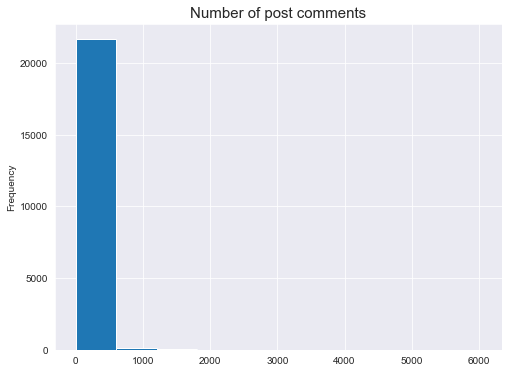

In [86]:
#code ref from Gwen's lab review lesson 4/27/2021

plt.figure(figsize = (8,6));
df['num_comments'].plot(kind='hist');
plt.title('Number of post comments', size =15);

In [ ]:
#check for post density
len(df['selftext'].mean())

In [ ]:
#<df>['title'].value_counts()

In [ ]:
#<df>['author'].value_counts() #get only unique

- - -

## Part III: NLP & feature eng

### Vectorize text in prep for analysis

In [ ]:
#vectorize self-text, title or joint column

### Word analysis

In [ ]:
#word freq analysis

In [ ]:
#sentiment analysis

In [ ]:
#pair-plot relationships btn. words

In [ ]:
#look at bi-grams / tri-grams
#consult Gwen's NLP lab review notebook (fb status analysis) for this!

- - -
## Modeling

Several classification models are availed to us. We will try the merits of different ones, potentially including:

* KNN
* Decision Trees
* Random Forest
* Bayes
* Logistic regression (NOTE: this one only makes sense if we find some linearity in earlier text relationship analysis)

We will tune and random-search for best parameters, where appropriate.